## 4️⃣ Create a Baseline Model

In [49]:
# Load libraries
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import statsmodels.stats.api as sms
from IPython.display import display
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

from R3_functions import chain_snap
from R4_functions import (
    diagnostic_plots,
    encode_categorical_features,
    get_variance_inflation_factors,
    plot_actual_vs_predicted_values,
    regression_report_in_sample_out_of_sample,
)


# set random seed
np.random.seed(42)

pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.width", 1000)

**1. Load both the train and validation datasets**

In [50]:
DATA_TRAIN_PATH = os.path.join("data", "data_train_processed.parquet")
DATA_VAL_PATH = os.path.join("data", "data_val_processed.parquet")

In [51]:
# Load the dataset processed in the previous
data_train = (
    pd.read_parquet(DATA_TRAIN_PATH)
    # double check missing values and duplicates
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="• Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="• Number of missing values in the dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.shape[0],
        msg="• Number of samples",
    )
)

data_val = (
    pd.read_parquet(DATA_VAL_PATH)
    # double check missing values and duplicates
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="• Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="• Number of missing values in the dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.shape[0],
        msg="• Number of samples",
    )
)

#display size of train and validation data respectively
print("• Train set dimension:",data_train.shape)
print("• Validation set dimension:",data_val.shape)

# Consider the log of the price as the target variable
TARGET = "log(Price)"

display(data_train.head(2))
display(data_val.head(2))

• Number of duplicate rows: 0
• Number of missing values in the dataset: 0
• Number of samples: 552
• Number of duplicate rows: 0
• Number of missing values in the dataset: 0
• Number of samples: 184
• Train set dimension: (552, 20)
• Validation set dimension: (184, 20)


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,635000.00,"Niersstraat 35 HS, Amsterdam",1078VH,81.00,3.00,4.89,52.34,13.36,4.39,1.10,1078,0,7,8,VH,27.00,3.30,3.32,3.35,0.03
1,400000.00,"Jan van Riebeekstraat 3 1, Amsterdam",1057ZW,61.00,2.00,4.86,52.37,12.90,4.11,0.69,1057,0,5,7,ZW,30.50,3.42,1.95,2.35,0.04


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.00,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.94,52.35,12.96,4.22,1.10,1098,0,9,8,TK,22.67,3.12,3.61,4.17,0.07
1,285000.00,"Kikkenstein 3534, Amsterdam",1104TT,96,4,4.97,52.32,12.56,4.56,1.39,1104,1,0,4,TT,24.00,3.18,7.35,8.21,0.14


In [52]:
# Split data in features and target
X_train, y_train = data_train.drop(TARGET, axis=1), data_train[TARGET]
X_val, y_val = data_val.drop(TARGET, axis=1), data_val[TARGET]

**2. Start to fit a simple model, i.e., [linear regression](https://www.statsmodels.org/stable/regression.html) for regression problems and [logistic regression](https://www.statsmodels.org/stable/discretemod.html) for classification problems.**
<!-- - use the [stastmodels](https://www.statsmodels.org/stable/index.html) API in this phase as they provide out-of-the-box comprehensive summary statistics.
- try to comply as much as possible with the model assumptions [[link ols](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/), [link logit](https://www.statology.org/assumptions-of-logistic-regression/)].

💁‍♂️ Apply one-hot encoding before fitting a model if you include categorial features in your model. -->

First, starting with fitting a model with all numeric features that have shown a significant correlation with the target shown previously; with all newly created categorical features **except for** `Zip_num`.

- Similar to the previous workbook, choosing log-transformed features reduces the influence of outliers and skewness. 

In [53]:
# Collect quantitative and categorical features
quantitative_features = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]

categorical_features = ["Region", "Location","District"]

# consider only quantitative features
X_train_num, X_val_num = X_train[quantitative_features], X_val[quantitative_features]

# apply one-hot encoding to categorical features
X_train_cat, X_val_cat = encode_categorical_features(
    X_train, X_val, categorical_features
)

# combine numerical and categorical features
X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_enc = pd.concat([X_val_num, X_val_cat], axis=1)

In [54]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 553
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Price               552 non-null    float64 
 1   Address             552 non-null    category
 2   Zip                 552 non-null    object  
 3   Area                552 non-null    float64 
 4   Room                552 non-null    float64 
 5   Lon                 552 non-null    float64 
 6   Lat                 552 non-null    float64 
 7   log(Price)          552 non-null    float64 
 8   log(Area)           552 non-null    float64 
 9   log(Room)           552 non-null    float64 
 10  Zip_num             552 non-null    int64   
 11  Region              552 non-null    int64   
 12  Location            552 non-null    int64   
 13  District            552 non-null    int64   
 14  Delivery_area       552 non-null    category
 15  AR-ratio            552 non-null    floa

In [55]:
# include intercept in the model
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc)
    X_val_sm = sm.add_constant(X_val_enc)
else:
    X_train_sm = X_train_enc.copy()
    X_val_sm = X_val_enc.copy()

# fit the model
model_fit = sm.OLS(y_train, X_train_sm).fit()

# show summary
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             log(Price)   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     179.9
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          4.20e-229
Time:                        08:49:50   Log-Likelihood:                 147.94
No. Observations:                 552   AIC:                            -249.9
Df Residuals:                     529   BIC:                            -150.7
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.0824      0

**3. Measure the [Variance Inflation Factor (VIF)](https://www.investopedia.com/terms/v/variance-inflation-factor.asp) for each model fit. If the VIF of each feature is below 5, continue to step 4; otherwise, go to step 2 before removing highly correlated features.**

In [56]:
# check for multicollinearity
warnings.filterwarnings("ignore")
get_variance_inflation_factors(X_train_enc)

,feature,VIF
0,log(Area),inf
1,log(Room),inf
2,log(AR-ratio),inf
3,Euclidean_distance,419.35
4,Haversine_distance,741.41
5,Manhattan_distance,101.72
6,Region_1,30.93
7,Location_1,49.92
8,Location_2,18.70
9,Location_3,18.05


* Despite the model achieving an R-squared of almost 0.9, all the predictors have a VIF > 5. 
    - This presence of multicollinearity is expected: as shown previously, we observed several features correlating with each other. 
    <!-- - Regarding categorical features, despite ANOVA showed statistical differences among means of log(Price) from each  `District` group; the coefficient for most of `District` groups were statistically no difference compared to the constant.   -->

* Based on the previous analysis, one can consider include only `log(Area)` and `Manathann_distance` for the baseline model. This is because: 
    - These two features seems highly correlated to target variable with VIF value below the threshold (i.e., VIF <5). 
    - `log(Room)` will not be included, as it has no impact to model explainability with detrimental impact on model fit when including. Furthermore, considering  it is highly correlated to `log(Area)`, making it less desirable to be included. 

In [57]:
# include quantitative features
quantitative_features = ["log(Area)", "Manhattan_distance"]

# include categorical features [None]
# adding 'Region' will not cause multicollinearity, however it does not improve the model explanatory power
categorical_features = [] 

# Get quantitative features
X_train_num, X_val_num = X_train[quantitative_features], X_val[quantitative_features]

# Apply one-hot encoding to categorical features
X_train_cat, X_val_cat = encode_categorical_features(
    X_train, X_val, categorical_features
)

# Combine numerical and categorical features
X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_enc = pd.concat([X_val_num, X_val_cat], axis=1)

In [58]:
# include intercept in the model
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc)
    X_val_sm = sm.add_constant(X_val_enc)
else:
    X_train_sm = X_train_enc.copy()
    X_val_sm = X_val_enc.copy()

# fit the model
model_fit = sm.OLS(y_train, X_train_sm).fit()

# show summary
print(model_fit.summary())

# check for multicollinearity
display(get_variance_inflation_factors(X_train_enc))

                            OLS Regression Results                            
Dep. Variable:             log(Price)   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1245.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          9.69e-205
Time:                        08:49:58   Log-Likelihood:                 30.189
No. Observations:                 552   AIC:                            -54.38
Df Residuals:                     549   BIC:                            -41.44
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.3848      0

,feature,VIF
0,log(Area),3.31
1,Manhattan_distance,3.31



* When only include `log(Area)` and `Manhattan_distance`, the VIF value for both predictors are between 1 and 5, indicating that multicollinearity was not a concern. In addition, the VIF values also indicated that these two variables are moderately correlated. 

* When including `Region`in addition to `log(Area)` and `Manhattan_distance`, despite the VIF values are below threshold of 5, indicating it will not cause multicollinearity; however, given it is statistically not significant, and does not improve the model explanatory power, I thus dropped it from the model in order to achieve parsimonious model. 

**4. Assess the feature’s importance and provide an interpretation of the overall model**

* Used standardised features to puts all variables on the same scale, to be comparable


**Model interpretation:**

The current model has been fitted using linear regression by regressing the *log(Price)* on two numerical variables, i.e., *log(Area)*, *Manhattan_distance*.  We can express the model as: 

$$\text{log(Price)} = \beta0 + \beta1_{log(Area)} + \beta2_{Distance}+ \varepsilon$$ 

During data pre-processing, we relied on log-transformation of both dependent and some of independent variables to reduce the influence of outliers and skewness. For the interpretation of coefficient with log-transformed variables refer to [link](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).
<!-- and categorical variables [link2](https://www.theanalysisfactor.com/interpreting-regression-coefficients/), respectively. -->


Looking at the summary output: 
- `Intercept`: refers to the mean of the dependent variable (i.e., target feature) when all of the explanatory variables are 0. 
- `log(Area)`: the relationship between log(Area) and log(Price) is statistically significant and positive (*p* < .001), indicating for every 1% increase in the *Area* in $m^{2}$, the house *Price* in Euro increases by about 0.9% while holding *Manhattan_distance* constant. 
   
    - Since this variable is log-transformed as the dependent variable, one should interpret the coefficient ($\beta_{log(Area)} = 0.9323$) as the percent increase in the dependent variable for every 1% increase in the independent variable.
    - One can also calculate the increasing percentage of the dependent variable for a given percent increase $p$ in the independent variable as $(1.p^{\theta} - 1) \times 100$ where $\theta$ denotes the coefficient. Example: For every *p=20%* increase in *Area*, the house price increases by about (1.20**0.9323 - 1) * 100 = 18.52%. 

- `Manhattan_distance`: the relationship between Manhattan_distance and log(Price) is statistically significant and negative(*p* < .001); indicating for every one-unit increase in the *Manhattan_distance*, the *Price* decreases by a factor of about np.exp(6.0253) = 413 Euro while holding *log(Area)* constant
    - In this case, only the target variable is log-transformed; hence, we need to exponentiate the coefficient ($\beta_{Distance} = -6.0253$)to yield the multiplicative factor for every one-unit increase in the independent variable. 


**Consideration regarding the Confidence Intervals**

In the Ordinary Least Square (OLS) summary generated by the stastmodel api, each parameter's confidence interval is also provided. The confidence interval represents the variability of our estimates. In this case, we would say that: 

*Using a sample of `n = 552`, we are 95% confident that `log(Area)` and `Manhattan_distance` are within the interval `[0.8920, 0.9725]` and `[-6.5029, -5.5477]` respectively.*


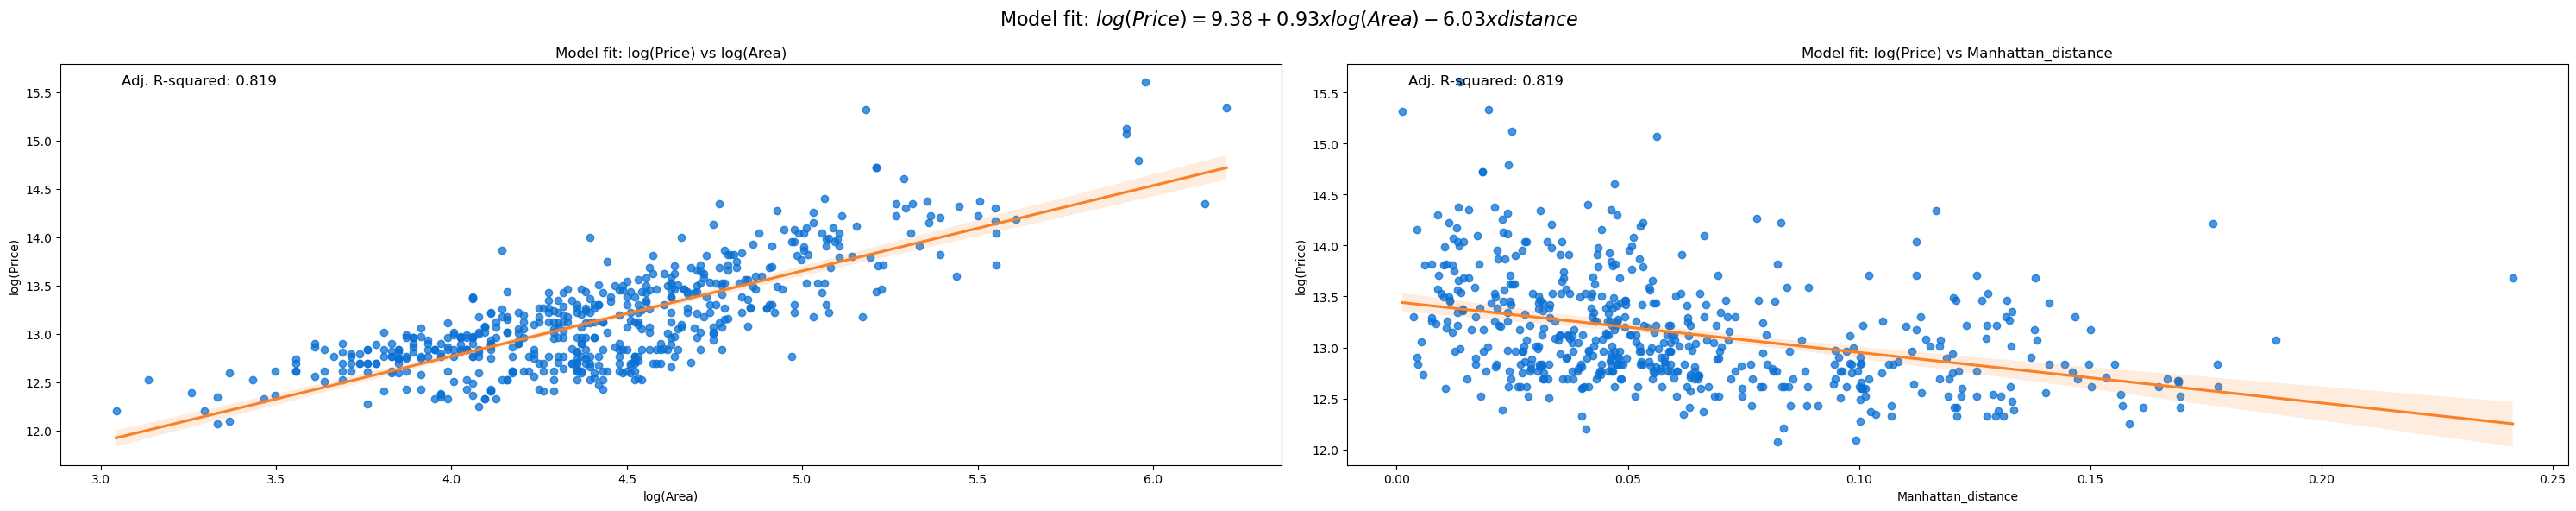

In [59]:
# Visualize model fit: 
# to do so, we create a visualization for each independent variable while holding the other independent variables constant.
df_plot = pd.concat([X_train, y_train], axis=1)


# List of predictor variables
predictors = ['log(Area)', 'Manhattan_distance']

# Create subplots in a single row
fig, axs = plt.subplots(1, len(predictors), figsize=(15 * len(predictors), 6))

# Iterate through the predictors and create plots
for i, predictor in enumerate(predictors):
    sns.regplot(
        data=df_plot,
        x=predictor,
        y="log(Price)",
        ax=axs[i],  # Specify the axis for the plot
        scatter_kws={"alpha": 0.75, "color": "#0B70D4"},
        line_kws={"color": "#F9812A"}
    )

    # Annotate adjusted R-squared
    axs[i].annotate('Adj. R-squared: {}'.format(round(model_fit.rsquared_adj, 3)),
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=12, color='black')

    # Set title for each plot
    text_title = f"Model fit: log(Price) vs {predictor}"
    axs[i].set_title(text_title)

text_title = "Model fit: $log(Price) = {const:.2f} + {log(Area):.2f} x log(Area) {Manhattan_distance:.2f} x distance$"
plt.suptitle(text_title.format(**model_fit.params.to_dict()), size=16)

# Adjust layout
plt.tight_layout()
plt.show()


* Assessing feature importance using standardised data: 
    * Since feature importance only require the coefficients, using `sklearn` package for this task would be sufficient. 
    * We also standardize the features to make a fair comparison by fitting a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) of [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) with [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). 

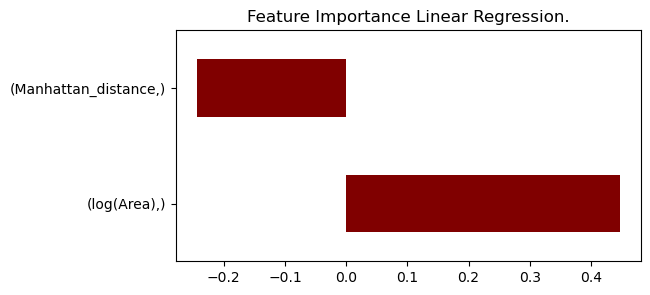

•log(Area) has 1.84 times more impact on the price than Manhattan_distance


In [60]:
# Feature importance
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("lr", LinearRegression(fit_intercept=True)),
    ]
)

_ = pipe.fit(X_train[quantitative_features + categorical_features], y_train)
# plot bar chart of feature importance
(
    pd.Series(
        pipe.named_steps["lr"].coef_,
        index=[quantitative_features + categorical_features],
    ).plot(
        kind="barh",
        color="maroon",
        figsize=(6, 3),
        title="Feature Importance Linear Regression.",
    )
)
plt.show()

# Print some information
text = "•log(Area) has {area:.2f} times more impact on the price than Manhattan_distance"
print(
    text.format(
        area=np.abs(pipe.named_steps["lr"].coef_[0] / pipe.named_steps["lr"].coef_[1])
    )
)

**5. Assess the model quality via** 
- [diagnostic plots](https://data.library.virginia.edu/diagnostic-plots/) if you are dealing with a regression problem.
- [performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) defined in 0️⃣ b) Define Analytical Needs;


**5.1 Model diagnostics**:

First, let's create diagnostic plots, which can create some visual aid helping us understand how our model is fitting the data and if any of the basic assumptions of an OLS model are being violated. 

In each of the plots from the **diganostic plots**, we look for the following:

- **Residuals versus fitted**: look for patterns that can indicate non-linearity, e.g. that the residuals all are high in some areas and low in others. The blue line is there to aid the eye - it should ideally be relatively close to a straight line (in this case, it isn’t perfectly straight, which could indicate a mild non-linearity).
- **Normal Q-Q**: see if the points follow the line, which would indicate that the residuals (which for this purpose can think of as estimates of the random errors) follow a normal distribution. In this case, the residuals are not closely following the diagonal line, indicating they may not be normally distributed.
- **Scale-Location**: similar to the residuals versus fitted plot, this plot shows whether the residuals are evenly spread for different values of the fitted values. Look for patterns in how much the residuals vary - if they e.g. vary more for large fitted values, then that is a sign of heteroscedasticity. A horizontal blue line is a sign of homoscedasticity.
- **Cook’s distance**: look for points with high values. A commonly-cited rule-of-thumb (Cook & Weisberg, 1982) says that values above 1 indicate points with a high influence.
- **Residuals versus leverage**: look for points with a high residual and high leverage. Observations with a high residual but low leverage deviate from the fitted model but don’t affect it much. Observations with a high residual and a high leverage likely have a strong influence on the model fit, meaning that the fitted model could be quite different if these points were removed from the dataset. In the current case, one could try to remove data point 347 and assess its impact on the output. 
- **Cook’s distance versus leverage**: look for observations with a high Cook’s distance and a high leverage, which are likely to have a strong influence on the model fit. Consistently, data point 347 seems plausible to have an impact on the model fit. 

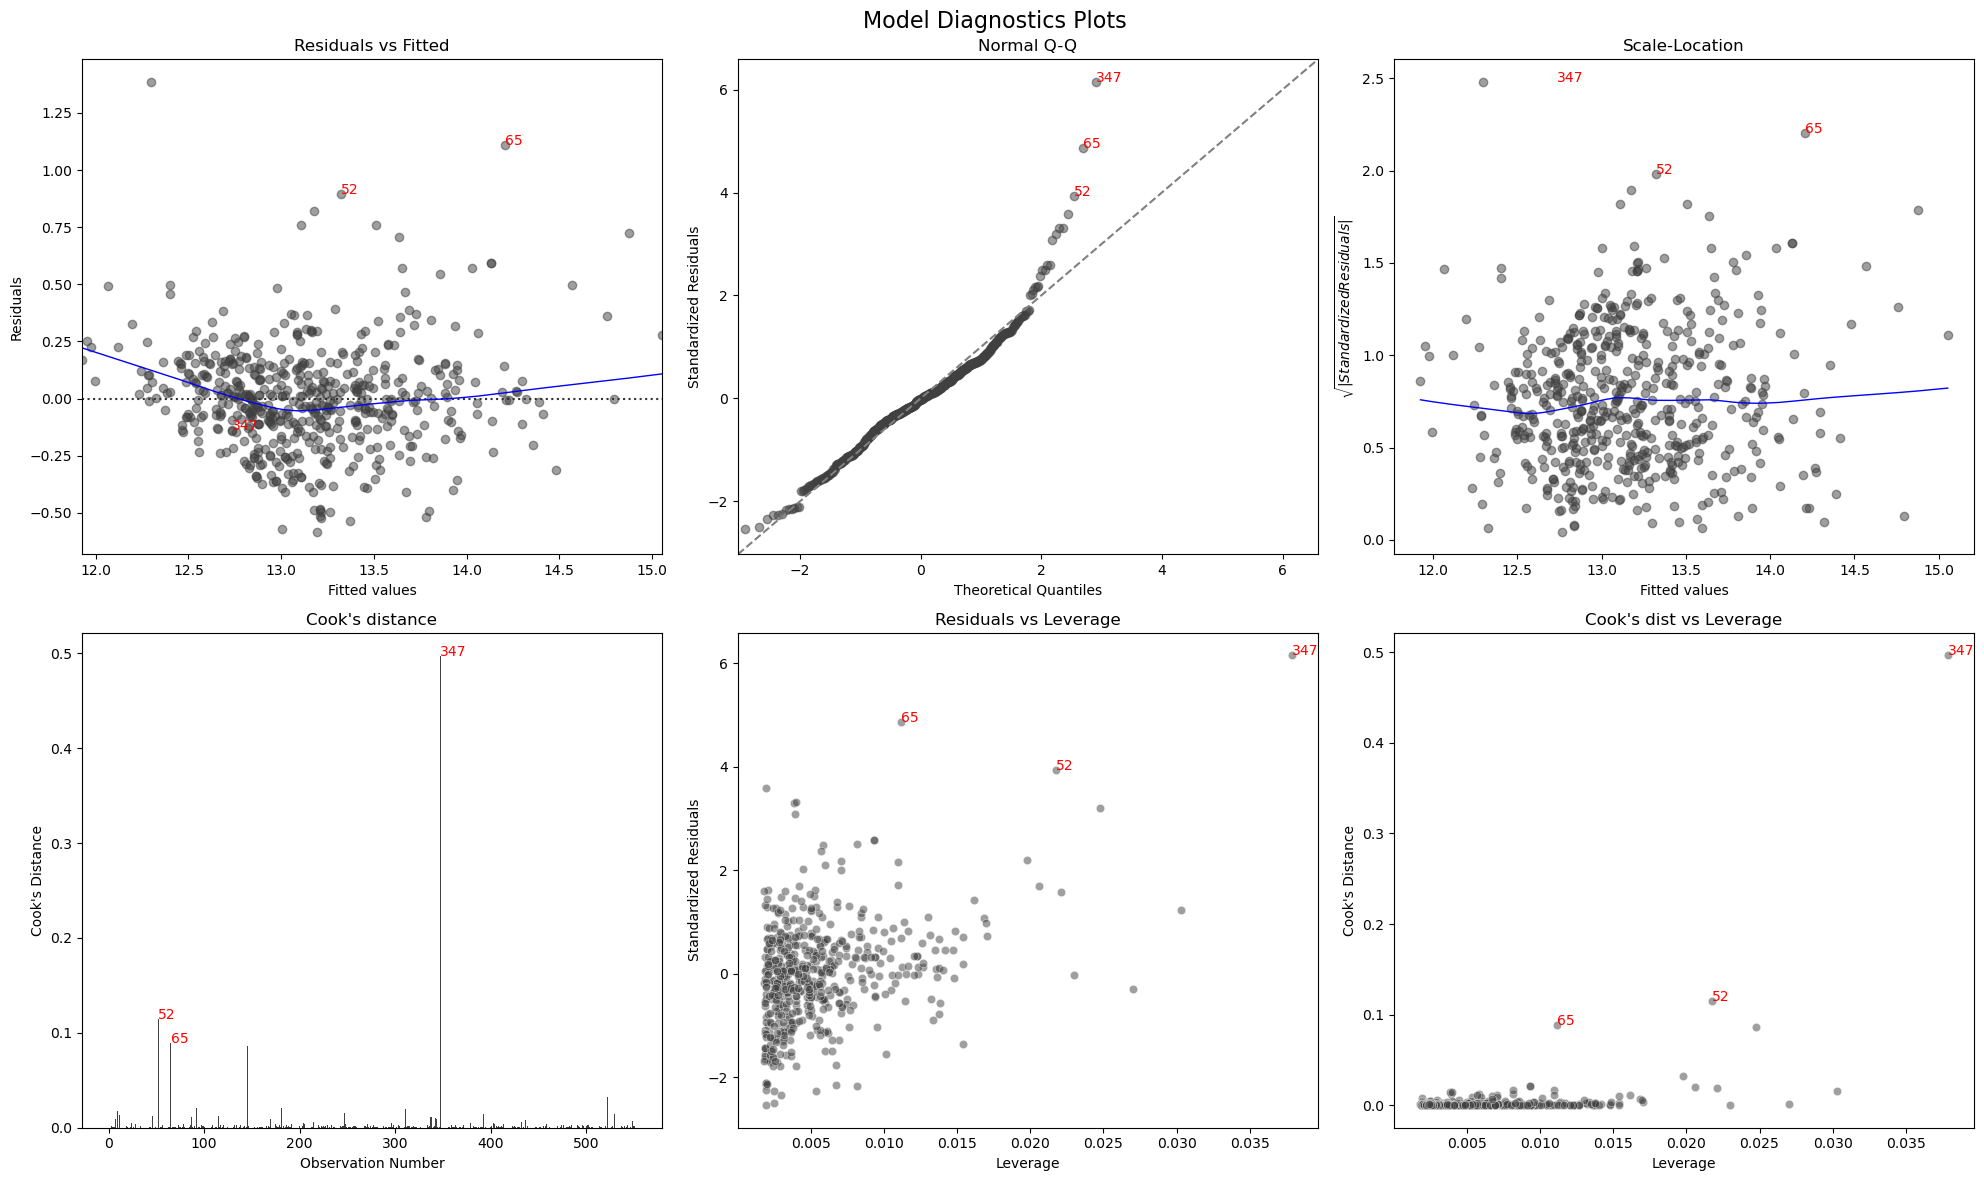

In [61]:
# Generate diagnostic plots based on customised function
diagnostic_plots(X_train_sm, 
                 y_train, 
                 model_fit=model_fit)

Next, lets perform some formal tests for OLS assumptions: 

- OLS *Assumption 1*: The error term has a population mean of zero

In [62]:
print("Mean of residuals:",round(np.mean(model_fit.resid, axis=0),2))
print('• This assumption is automatically met, due to the inclusion of constant.')

Mean of residuals: 0.0
• This assumption is automatically met, due to the inclusion of constant.


- OLS *Assumption 2*: The regression model is linear in the coefficients
    - Based on the previous **Residuals vs. Fitted plot** one can already suspect there exists mild non-linear pattern in the data.
    - The [Ramsey RESET Test](https://cran.r-project.org/web/packages/lmtest/lmtest.pdf) is used to determine whether any nonlinear combination of the explanatory variables can help explain the dependent variable ([Documentation](https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.linear_reset.html)).

In [63]:
# Model diagnostics: Linearity test (Ramsey RESET Test)
import statsmodels.stats as ss
linearity = ss.diagnostic.linear_reset(model_fit, power=2, test_type='fitted', \
                                          use_f=True, cov_type='HC3', cov_kwargs=None)

print(f"F-value: {linearity.statistic:.2f}")
print(f"p-value: {linearity.pvalue:.3f}")

alpha=0.05
if linearity.pvalue <= alpha:
    print(f"• The result suggests that there is a non-linear relationship between target and feature variables.")
else: 
     print(f"• The result suggests that there is a linear relationship between target and feature variables.")

F-value: 30.11
p-value: 0.000
• The result suggests that there is a non-linear relationship between target and feature variables.


Next, we test for OLS efficiency property

- OLS *Assumption 3*: The error term has a constant variance (no heteroscedasticity)

    - The [Breusch-Pagan Test](https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/) is used to determine whether or not heteroscedasticity is present in a regression model ([Documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html)). A low p-value indicates statistical evidence for heteroscedasticity.

In [64]:
import statsmodels.stats as ss

# concat predictor and outcome variables in the same dataframe
data_reg = pd.concat([X_train_sm, y_train], axis=1)
x = data_reg[['const','log(Area)', 'Manhattan_distance']]

breuschpagan = ss.diagnostic.het_breuschpagan(model_fit.resid, x, robust=True)
     
print(f"F-value: {breuschpagan[2]:.2f}")
print(f"p-value: {breuschpagan[3]:.3f}")

alpha=0.05
if breuschpagan[3]<= alpha:
    print(f"• The result suggests that the error term is heteroskedastic.")
else: 
     print(f"• The result suggests that the error term is homoskedastic.")


F-value: 12.40
p-value: 0.000
• The result suggests that the error term is heteroskedastic.


- OLS *Assumption 4*: Observations of the error term are uncorrelated with each other
    - From the above output, the `Durbin-Watson`showed value of 2, indicating the absence of first-order auto-correlation in the error term. 
    - Simialrly, we can use the [Breusch-Godfrey Test](https://www.statology.org/breusch-godfrey-test-python/) to test for autocorrelation in the errors in a regression model ([Documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_breusch_godfrey.html)).

In [65]:
lags = 1
acorr = ss.diagnostic.acorr_breusch_godfrey(model_fit, nlags=lags)

print(f"F-value: {acorr[2]:.2f}")
print(f"p-value: {acorr[3]:.3f}")


alpha=0.05
if acorr[3]<= alpha:
    print(f"• The result suggests that the error term has auto-correlation of order {lags}.")
else: 
     print(f"• The result suggests that the error term has no auto-correlation of order {lags}.")

F-value: 0.54
p-value: 0.464
• The result suggests that the error term has no auto-correlation of order 1.


Based on the above two tests, we need to correct for heteroscedasticity.

- The NeweyWest estimator produces standard errors robust to both heteroscedasticity and autocorrelation (cov_type='HAC')
- The White estimator produces standard errors robust to heteroscedasticity only (cov_type='HC3')

In [66]:
# Using the Newey West estimator fit the model
model_fit_nw = sm.OLS(y_train, X_train_sm).fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t= True)
# Using the White estimator 
# model_fit_w = sm.OLS(y_train, X_train_sm).fit(cov_type='HC3', use_t= True)


# show summary with corrected standard errors
print(model_fit_nw.summary())
# print(model_fit_w.summary())

                            OLS Regression Results                            
Dep. Variable:             log(Price)   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     855.5
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          2.04e-169
Time:                        08:50:28   Log-Likelihood:                 30.189
No. Observations:                 552   AIC:                            -54.38
Df Residuals:                     549   BIC:                            -41.44
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.3848      0

- OLS *Assumption 5*: The error term is normally distributed
    - The [Jarque-Bera Test](https://www.statisticshowto.com/jarque-bera-test/) is used to test whether the sample data has the skewness and kurtosis matching a normal distribution([Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html)).

As can be observed in the output table, the `Jarque-Bera (JB)` test rejects the null hypothesis (p<.001), which indicates that the error term is not normally distributed. Further visualisation of the error term also indicated the presence of high kurtosis.

Chi-squared statistic: 431.25
p-value: 0.000
• The result suggests that the error term is not normally distributed.


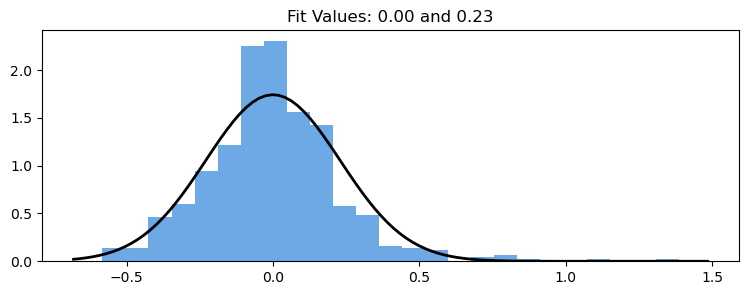

In [67]:
from scipy import stats
from scipy.stats import norm

normality = stats.jarque_bera(model_fit.resid)

print(f"Chi-squared statistic: {normality.statistic:.2f}")
print(f"p-value: {normality.pvalue:.3f}")

alpha=0.05
if normality.pvalue <= alpha:
    print(f"• The result suggests that the error term is not normally distributed.")
else: 
     print(f"• The result suggests that the error term is not normally distributed.")


# Fit a normal distribution to the data: mean and standard deviation
mu, std = norm.fit(model_fit.resid) 
  
# Plot the histogram.
plt.figure(figsize=(9, 3)) 
plt.hist(model_fit.resid, bins=25, density=True, alpha=0.6, color='#0B70D4')

  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.show()

From the above normality test result and the visualisation, we can deduce that the errors are not normally distributed because they exhibit high kurtosis and positive skewness. 

We can derive robust inferences using **bootstrapping** (i.e., the empirical distribution of beta):

In [68]:
# creating empty list so the results of each coefficeints can be appended
betas_summary = {'log_area_beta':[],
                 'Manhattan_distance_beta':[]}

# creating 999 bootstrap samples
bs = range(1,1000,1) 

for i in bs:
    # Creating a bootstrap sample with replacement
    bootsample = data_reg.sample(n=data_reg.shape[0], replace=True)
    # Fitting the model with the bootstrap sample
    model = sm.OLS(bootsample['log(Price)'], bootsample[['const','log(Area)','Manhattan_distance']], data = bootsample).fit()
    #appending the results of each coefficient
    betas_summary['log_area_beta'].append(model.params['log(Area)'])
    betas_summary['Manhattan_distance_beta'].append(model.params['Manhattan_distance'])

In [69]:
#To compare the bootstrapped coefficients with the original coefficients
#First, compute the mean and 95% confidence interval of the bootstrapped coefficients
boots_coeff = pd.DataFrame(betas_summary)
mean_coeff = boots_coeff.mean(axis=0)
quantile_coeff = boots_coeff.quantile([0.025, 0.975])


betas_coeff_summary = {'mean': mean_coeff,
                      '2.5quantile':quantile_coeff.iloc[0,:],
                      '97.5quantile':quantile_coeff.iloc[1,:]}

betas_coeff_summary = pd.DataFrame(betas_coeff_summary).reset_index()
betas_coeff_summary.set_index('index', inplace=True)

#results are quite similar to the model coefficients and confidence interval
betas_coeff_summary 

,mean,2.5quantile,97.5quantile
index,,,
log_area_beta,0.93,0.89,0.97
Manhattan_distance_beta,-6.04,-6.69,-5.34


**In summary**, from **model diagnostics** and subsquent corrections, we learned that: 

* Model diagnostic plots showed non-linear patterns that the model has not been able to capture and heteroskedasticity phenomenon. 
    * Using the Newey-West estimator to correct for heteroskedasticity, we observe that our inferences do not change substantially 

* Diagnostic plots also indicated there might be presence of high leverage, high influence and high residual point impact on model fit.
    * Re-ran the model with removing data point 347, the R^2 slightly improved to 0.832 from 0.819, indicating the presence of this outlier is not significantly impacting on model fit. Given this, one may consider this data point might not necessarily be a highly influential point
    
* Results from normality test result and the visualisation, we can deduce that the errors are not normally distributed because they exhibit high kurtosis and positive skewness. 
    * Using bootstrap intervals, the results indicate that our inferences are robust to non-normality of errors 



**5.2 Model performance**
- **R-squared**: also known as *Coefficient of Determination*. It provides a measure of the goodness of fit. If `r2-square=1`  means that the fit is perfect, i.e. the estimated values of the model fit coincide with the measurements. A `r2-square=0` denotes that the model is not able to explain any of the data.
- **Explained variance regression score**:  It measures the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set. Essentially, it quantifies how much of the variance in the dependent variable is "explained" by the model. 
    - The difference is that the explained variance use the biased variance to determine what fraction of the variance is explained. R-Squared uses the raw sums of squares. If the error of the predictor is unbiased, the two scores are the same.
    - Moreover, another key difference lies in their sensitivity to the model's ability to accurately capture dependent variable variance. The R2 score is sensitive to outliers and can be negatively impacted by overfitting, while the explained variance score is more robust in these aspects.
    - If explained variance is good but R2 score is not, it could indicate systematic bias in the predictions
- **Root Mean Square Error (RMSE)** It measures the average difference between values predicted by a model and the actual values. The lower the value of the RMSE, the better the model is. A perfect model (a hypothetic model that would always predict the exact expected value) would have a Root Mean Squared Error value of 0. Finally, RMSE has the same unit of the target.
- **Mean Absolute Error (MAE)**  It is measured as the average absolute difference between the predicted values. The lower the value of the MAE, the better the model is. Futhermore, MAE has the same unit of the target. Compared to RMSE:
    - MAE is less sensitive to outliers;
    - MAE penalises large errors less than RMSE due to the fact that errors are not squared initially
    - MAE returns values that are more interpretable as it is simply the average of absolute error
- **Max Error**: The maximum residual error

The model performance is assessed by back-transforming the target `log(Price)` to `Price`. Note that, according to this [article](https://www.r-bloggers.com/2013/08/forecasting-from-log-linear-regressions/amp/) one should retrieve model prediction $\hat{y}$ in the original scale via $\hat{y} = e^{\hat{y}} + \frac{s^{2}}{2}$, where $s^{2}$ denotes the unbiased estimator of the variance $\sigma^{2}$ of the model error term. $s^{2}$ can be calculated as $s^{2} = \frac{\sum_{1}^{n} (log(y) - f(x))^2}{n-k}$ with $n$ is the number of samples, $k$ the number of predictors (excluding the intercept) and $y$ the target value in the training set.

In [70]:
def back_transform_output_sm(X_train, X_val, model_fit):
    """Convert model output from log(y) to y tailored for stastmodels"""

    # get number of sample and number of features
    n, k = X_train.shape[0], X_train.shape[1]
    s2 = np.sum(model_fit.resid**2) / (n - k)

    # get model fit in original scale (in-sample)
    y_fit = np.exp(model_fit.predict(X_train)) + s2 / 2

    # get model fit in original scale (out-of-sample)
    y_pred = np.exp(model_fit.predict(X_val)) + s2 / 2

    return y_fit, y_pred

In [71]:
# create empty dataframe to store results
df_report_all = pd.DataFrame()

In [72]:
y_fit, y_pred = back_transform_output_sm(X_train_sm, X_val_sm, model_fit)

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train),
    y_fit=y_fit,
    y_test=np.exp(y_val),
    y_pred=y_pred,
    model_name="OLS",
)

# display report with extended width
display(df_report)

# append to dataframe
df_report_all = df_report_all.append(df_report)

in-sample  out-of-sample  Difference (%)                     Description
model metrics                                                                                     
OLS   r-squared                0.74           0.71           -4.94    Coefficient of Determination
      explained variance       0.75           0.72           -3.61        Explained Variance Score
      RMSE                261417.59      246345.15           -6.12  Root Mean Squared Error (RMSE)
      MAE                 112400.46      128421.29           12.48       Mean Absolute Error (MAE)
      max error          3068368.56     1768201.06          -73.53      The maximum residual error

 * The model explains 75% and 72% of the variance in-sample and out-of-sample sets, respectively. However, the RMSE, MAE and the max error appear too large for this type of application.

**6. Keep track of the model performance and annotate your baseline model. As a final check, you can:**
- show the scatter plot between the [predicted values versus the actual](https://statisticsglobe.com/plot-predicted-vs-actual-values-in-r) for both training and validation set for a regression problem;
- the [decision boundary](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) in the case of a classification problem. 

💁‍♀️ Aim to retrieve a model with the least amount of predictors while achieving a desired level of performance.


**Plot the predicted vs. actual values**

Let's plot two equal graphs, but the second one zoomed in the range up to 2M Euros.

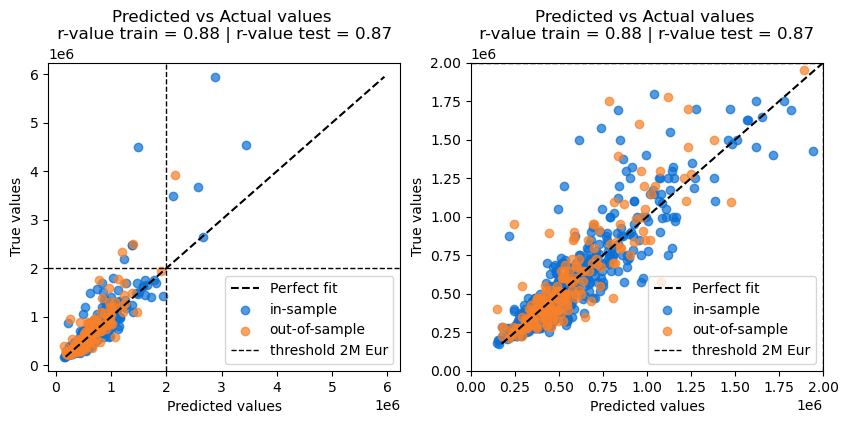

In [77]:
# Plot pred vs actual values (note we exponentiate the target variable)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot sample plot but the second one zoomed in up to 2M Eur
for j in [0, 1]:
    axs[j].plot(
        [np.exp(y_train.min()), np.exp(y_train.max())],
        [np.exp(y_train.min()), np.exp(y_train.max())],
        "--k",
    )
    axs[j].scatter(x=y_fit, y=np.exp(y_train), c='#0B70D4', alpha=0.7)
    axs[j].scatter(x=y_pred, y=np.exp(y_val),  c='#F9812A', alpha=0.7)

    # add horizontal and vertical lines
    axs[j].axhline(y=2e6, color="k", linestyle="--", linewidth=1)
    axs[j].axvline(x=2e6, color="k", linestyle="--", linewidth=1)

    # add legend
    axs[j].legend(["Perfect fit", "in-sample", "out-of-sample", f"threshold 2M Eur"])
    axs[j].set_xlabel("Predicted values")
    axs[j].set_ylabel("True values")
    axs[j].set_title(
        f"Predicted vs Actual values \n r-value train = {np.corrcoef(np.exp(y_train), y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(np.exp(y_val), y_pred)[0,1]:.2f} "
    )
    if j == 1:
        # set x and y limits
        axs[j].set_xlim([0, 2e6])
        axs[j].set_ylim([0, 2e6])

        # overwrite title
        axs[j].set_title(
            f"Predicted vs Actual values \n r-value train = {np.corrcoef(np.exp(y_train), y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(np.exp(y_val), y_pred)[0,1]:.2f} "
        )

* The predictions are reasonably accurate when the house price is less than 2 Million Eur. However, starting from 1 Million Euros, the model tends to underestimate the house price as the price increases.

* To mitigate this issue and improve the quality of the predictions, one could restrict the range where we fit the data up to 2 Million and provide a warning in production environment if the model output is > 2 Million.

In [26]:
# Restrict the analysis to samples with price < 2M or
threshold = 2e6  # CUSTOMIZABLE threshold

# discard target values > threshold
y_train_bounded = y_train.loc[y_train < np.log(threshold)]
y_val_bounded = y_val.loc[y_val < np.log(threshold)]

# discard all sample in X_train_enc and X_val_enc with price > 2M
X_train_enc_bounded = X_train_enc.loc[y_train < np.log(threshold), :]
X_val_enc_bounded = X_val_enc.loc[y_val < np.log(threshold), :]

# count the number of samples before and after bounding
print(f"• Model fitting with threshold up to {threshold}")
print(f"• Number of samples before bounding: {X_train_enc.shape[0]}")
print(f"• Number of samples after bounding: {X_train_enc_bounded.shape[0]}")
# provide difference in percentage
print(
    f"• Difference in percentage: {(X_train_enc_bounded.shape[0] - X_train_enc.shape[0]) / X_train_enc_bounded.shape[0] * 100:.2f}%"
)

• Model fitting with threshold up to 2000000.0
• Number of samples before bounding: 552
• Number of samples after bounding: 543
• Difference in percentage: -1.66%


In [27]:
# include intercept in the model
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc_bounded)
    X_val_sm = sm.add_constant(X_val_enc_bounded)
else:
    X_train_sm = X_train_enc_bounded.copy()
    X_val_sm = X_val_enc_bounded.copy()

# fit the model
model_fit = sm.OLS(y_train_bounded, X_train_sm).fit()

# show summary
display(model_fit.summary2())

# check for multicollinearity
display(get_variance_inflation_factors(X_train_enc))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:               OLS              Adj. R-squared:     0.799    
Dependent Variable:  log(Price)       AIC:                -116.6654
Date:                2024-01-11 08:37 BIC:                -103.7741
No. Observations:    543              Log-Likelihood:     61.333   
Df Model:            2                F-statistic:        1081.    
Df Residuals:        540              Prob (F-statistic): 1.58e-189
R-squared:           0.800            Scale:              0.046970 
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               9.5814   0.0908 105.5300 0.0000  9.4031  9.7598
log(Area)           0.8815   0.0207  42.5707 0.0000  0.8409  0.9222
Manhattan_distance -5.7300   0.2326 -24.6390 0.0000 -6.1868 -5.2731
-------------------------------------------------------------------
Omnibus:               98.377       Durbin-Watson:          2.044  
Prob(Omnibus):         0.000        Jarque-Bera (JB):       388.816
Skew:                  0.768        Prob(JB):               0.000  
Kurtosis:              6.850        Condition No.:          114    
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

,feature,VIF
0,log(Area),3.31
1,Manhattan_distance,3.31


in-sample  out-of-sample  Difference (%)                     Description
model     metrics                                                                                     
OLS (<2M) r-squared                0.79           0.72           -9.78    Coefficient of Determination
          explained variance       0.79           0.73           -8.23        Explained Variance Score
          RMSE                147571.71      181023.07           18.48  Root Mean Squared Error (RMSE)
          MAE                  91023.51      111734.70           18.54       Mean Absolute Error (MAE)
          max error           897621.88      989269.04            9.26      The maximum residual error

• Plot with threshold 2M Eur


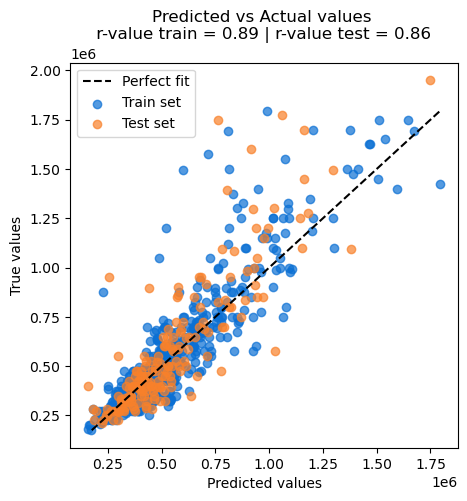

In [28]:
y_fit, y_pred = back_transform_output_sm(X_train_sm, X_val_sm, model_fit)

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_bounded),
    y_fit=y_fit,
    y_test=np.exp(y_val_bounded),
    y_pred=y_pred,
    model_name="OLS (<2M)",
)

# display report with extended width
display(df_report)

# append to dataframe
df_report_all = df_report_all.append(df_report)

# show newly plot actual vs predicted values
print(f"• Plot with threshold {int(threshold/1e6)}M Eur")
_, _ = plot_actual_vs_predicted_values(
    y_train=np.exp(y_train_bounded),
    y_fit=y_fit,
    y_test=np.exp(y_val_bounded),
    y_pred=y_pred,
)

The model explains 79% and 73% of the variance in-sample and out-of-sample sets, respectively. The current performance is satisfactory since the `r-squared > 0.7` requirement is met. However, the RMSE and MAE are still relatively high. Such inaccuracy can be at the most acceptable if the house price is in the higher price range. Further analysis will be carried out, and ML techniques will be leveraged to reduce the model inaccuracy.

Attempt to reduce heteroscedasticity via using a **Weighted Least Squares (WLS)** approach [Ref Link](https://www.statology.org/weighted-least-squares-in-python/).

In [29]:
# Retrieve the residuals and the the fitted values from the previous model
resid = model_fit.resid.abs()
y_fit = model_fit.fittedvalues

# Define weights to use
wt = 1 / sm.OLS(resid, y_fit).fit().fittedvalues ** 2

# Fit weighted least squares regression model
model_fit = sm.WLS(y_train_bounded, X_train_sm, weights=wt).fit()

# view summary of weighted least squares regression model
display(model_fit.summary())

# check for multicollinearity (the same as before)
display(get_variance_inflation_factors(X_train_enc))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             log(Price)   R-squared:                       0.794
Model:                            WLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1042.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          4.00e-186
Time:                        08:37:12   Log-Likelihood:                 61.385
No. Observations:                 543   AIC:                            -116.8
Df Residuals:                     540   BIC:                            -103.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.6116      0.091    105.956      0.000       9.433       9.790
log(Area)              0.8740      0.021     41.892      0.000       0.833       0.915
Manhattan_distance    -5.6789      0.230    -24.648      0.000      -6.131      -5.226
==============================================================================
Omnibus:                      111.253   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.869
Skew:                           0.834   Prob(JB):                    3.86e-110
Kurtosis:                       7.415   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,feature,VIF
0,log(Area),3.31
1,Manhattan_distance,3.31


in-sample  out-of-sample  Difference (%)                     Description
model     metrics                                                                                     
WLS (<2M) r-squared                0.79           0.71          -10.10    Coefficient of Determination
          explained variance       0.79           0.73           -8.39        Explained Variance Score
          RMSE                148117.74      181907.18           18.58  Root Mean Squared Error (RMSE)
          MAE                  91268.94      112160.98           18.63       Mean Absolute Error (MAE)
          max error           898489.21      992119.95            9.44      The maximum residual error

• Plot with threshold 2M Eur


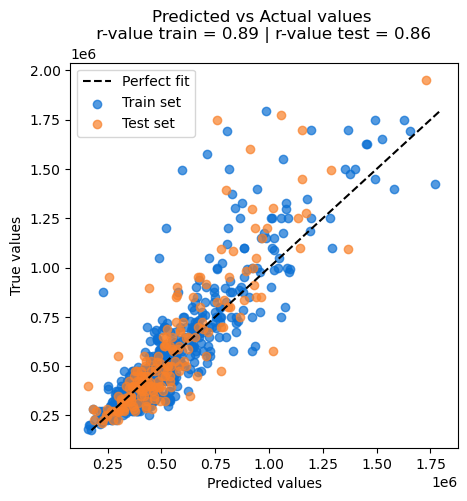

In [30]:
y_fit, y_pred = back_transform_output_sm(X_train_sm, X_val_sm, model_fit)

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_bounded),
    y_fit=y_fit,
    y_test=np.exp(y_val_bounded),
    y_pred=y_pred,
    model_name="WLS (<2M)",
)

# display report with extended width
display(df_report)

# append to dataframe
df_report_all = df_report_all.append(df_report)

# show newly plot actual vs predicted values
print(f"• Plot with threshold {int(threshold/1e6)}M Eur")
_, _ = plot_actual_vs_predicted_values(
    y_train=np.exp(y_train_bounded),
    y_fit=y_fit,
    y_test=np.exp(y_val_bounded),
    y_pred=y_pred,
)

**Summary report for all analyses**

In [31]:
display(df_report_all)

in-sample  out-of-sample  Difference (%)                     Description
model     metrics                                                                                     
OLS       r-squared                0.74           0.71           -4.94    Coefficient of Determination
          explained variance       0.75           0.72           -3.61        Explained Variance Score
          RMSE                261417.59      246345.15           -6.12  Root Mean Squared Error (RMSE)
          MAE                 112400.46      128421.29           12.48       Mean Absolute Error (MAE)
          max error          3068368.56     1768201.06          -73.53      The maximum residual error
OLS (<2M) r-squared                0.79           0.72           -9.78    Coefficient of Determination
          explained variance       0.79           0.73           -8.23        Explained Variance Score
          RMSE                147571.71      181023.07           18.48  Root Mean Squared Error (RMSE)
          MAE                  91023.51      111734.70           18.54       Mean Absolute Error (MAE)
          max error           897621.88      989269.04            9.26      The maximum residual error
WLS (<2M) r-squared                0.79           0.71          -10.10    Coefficient of Determination
          explained variance       0.79           0.73           -8.39        Explained Variance Score
          RMSE                148117.74      181907.18           18.58  Root Mean Squared Error (RMSE)
          MAE                  91268.94      112160.98           18.63       Mean Absolute Error (MAE)
          max error           898489.21      992119.95            9.44      The maximum residual error

In [32]:
# Group performance by metrics for a better comparison between models
for score in ["r-squared", "RMSE", "MAE"]:
    ascending = False if score == "r-squared" else True
    display(
        df_report_all
        # access dataframe with multi-index using query
        .query(f"metrics == '{score}'")
        # sort values base on out-of-sample score
        .sort_values(by="out-of-sample", ascending=ascending)
    )
print("NOTE: First row is the BEST performing model.")

,,in-sample,out-of-sample,Difference (%),Description
model,metrics,,,,
OLS (<2M),r-squared,0.79,0.72,-9.78,Coefficient of Determination
WLS (<2M),r-squared,0.79,0.71,-10.10,Coefficient of Determination
OLS,r-squared,0.74,0.71,-4.94,Coefficient of Determination


,,in-sample,out-of-sample,Difference (%),Description
model,metrics,,,,
OLS (<2M),RMSE,147571.71,181023.07,18.48,Root Mean Squared Error (RMSE)
WLS (<2M),RMSE,148117.74,181907.18,18.58,Root Mean Squared Error (RMSE)
OLS,RMSE,261417.59,246345.15,-6.12,Root Mean Squared Error (RMSE)


,,in-sample,out-of-sample,Difference (%),Description
model,metrics,,,,
OLS (<2M),MAE,91023.51,111734.70,18.54,Mean Absolute Error (MAE)
WLS (<2M),MAE,91268.94,112160.98,18.63,Mean Absolute Error (MAE)
OLS,MAE,112400.46,128421.29,12.48,Mean Absolute Error (MAE)


NOTE: First row is the BEST performing model.


**7. Pick the baseline model and newly train the corresponding model, this time using the [sklearn API](https://scikit-learn.org/stable/). Carry out basic checks to assess the correctness of the model.**


* As a **benchmark model** we wiil consider a `LinearRegression` trained within a range of `price < 2M Eur` with `log(Area)`,  `Manhattan_distance` as predictor variables. 

In [33]:
# Collect the data to be used for the model and double check that they are the right one
display(X_train_enc_bounded.head(2))
display(X_val_enc_bounded.head(2))
display(y_train_bounded.head(2))
display(y_val_bounded.head(2))

# check that the maximum value of the target variable is below the threshold (2M)
print(f"• Maximum value of the target variable (): {np.exp(y_train_bounded).max():.2f}")

# store coefficients of the baseline model retrieved using stastmodel API
sm_coef_ = pd.Series(
    {"const": 9.5814, "log(Area)": 0.8815, "Manhattan_distance": -5.7300}
)
display(sm_coef_)

,log(Area),Manhattan_distance
0,4.39,0.03
1,4.11,0.04


,log(Area),Manhattan_distance
0,4.22,0.07
1,4.56,0.14


0   13.36
1   12.90
Name: log(Price), dtype: float64

0   12.96
1   12.56
Name: log(Price), dtype: float64

• Maximum value of the target variable (): 1795000.00


const                 9.58
log(Area)             0.88
Manhattan_distance   -5.73
dtype: float64

In [34]:
# Fit Simple linear Regression model using scikit-learn API
reg = LinearRegression(fit_intercept=True).fit(X_train_enc_bounded, y_train_bounded)

# Display model
display(reg)

LinearRegression()

**8. Save the model as a [pickle](https://scikit-learn.org/stable/model_persistence.html) file together with its model performance and relevant metadata.** 

🚨This model is not production ready.


In [35]:
# Generate folder name
MODEL_NAME = "baseline_model"
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
FOLDER_NAME = f"{timestamp}_{MODEL_NAME}"
print("• Artifacts will be saved in the folder: ", FOLDER_NAME)

• Artifacts will be saved in the folder:  2024-01-11-08-37-12_baseline_model


In [36]:
# Create folder if not exists
ARTIFACTS_DIR = "./artifacts"
if not os.path.exists(os.path.join(ARTIFACTS_DIR, FOLDER_NAME)):
    os.makedirs(os.path.join(ARTIFACTS_DIR, FOLDER_NAME))

# Save model as a pickle file
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "wb") as f:
    pickle.dump(reg, f)

In [37]:
# load model and perform sanity check
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "rb") as f:
    baseline = pickle.load(f)

baseline

LinearRegression()

In [38]:
# Retrieve the coefficients of the baseline model retrieve using scikit-learn API
sk_coef_ = pd.Series(
    np.concatenate((np.array([baseline.intercept_]), baseline.coef_)),
    index=["const"] + X_train_enc_bounded.columns.tolist(),
)
display(sk_coef_)

# Check that coeffcient are the same with the previous model computed using stastmodel
assert np.allclose(sm_coef_, sk_coef_, atol=1e-3), "Coefficients are not the same"

const                 9.58
log(Area)             0.88
Manhattan_distance   -5.73
dtype: float64

In [39]:
# Retrieve the coefficients of the baseline model retrieve using scikit-learn API
sk_coef_ = pd.Series(
    np.concatenate((np.array([baseline.intercept_]), baseline.coef_)),
    index=["const"] + X_train_enc_bounded.columns.tolist(),
)
display(sk_coef_)

# Check that coeffcient are the same with the previous model computed using stastmodel
assert np.allclose(sm_coef_, sk_coef_, atol=1e-3), "Coefficients are not the same"

const                 9.58
log(Area)             0.88
Manhattan_distance   -5.73
dtype: float64

In [40]:
# Generate report for the baseline model and compare it with the previous one
y_fit = np.exp(baseline.predict(X_train_enc_bounded))
y_pred = np.exp(baseline.predict(X_val_enc_bounded))

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_bounded),
    y_fit=y_fit,
    y_test=np.exp(y_val_bounded),
    y_pred=y_pred,
    model_name="OLS (<2M)",
)

display(df_report)

# Store the report in a dataframe
df_report.to_csv(
    os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + "_performance.csv")
)

in-sample  out-of-sample  Difference (%)                     Description
model     metrics                                                                                     
OLS (<2M) r-squared                0.79           0.72           -9.78    Coefficient of Determination
          explained variance       0.79           0.73           -8.23        Explained Variance Score
          RMSE                147571.71      181023.07           18.48  Root Mean Squared Error (RMSE)
          MAE                  91023.51      111734.70           18.54       Mean Absolute Error (MAE)
          max error           897621.90      989269.06            9.26      The maximum residual error

* For simplicity's, the output coming from the baseline model has been computed as $\hat{y} = e^{\hat{y}}$ instead of the previous cases $\hat{y} = e^{\hat{y}} + \frac{s^{2}}{2}$. Yet, the model performance shown above is almost equal compared to the case, which includes $\frac{s^{2}}{2}$. For this reason, from now on, we will omit this term whenever we train a regression in the next phase.

In [41]:
Metadata = f"""
---
library_name: sklearn
tags:
- Dutch house price prediction
- tabular-regression
license: NA
datasets:
- {DATA_TRAIN_PATH}
- {DATA_VAL_PATH}
model: 
- 'linear regression'
metrics:
- 'r-squared'
features:
- {X_train_enc_bounded.columns.tolist()}
target:
- {y_train_bounded.name}
additional_information: 
- Dataset is bounded to samples with price < 2M
- The Dataset contains only houses from Amsterdam
- IMPORTANT: this model is not production ready
---
"""

# store string as a markdown file
with open(
    os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + "_metadata.md"), "w"
) as f:
    f.write(Metadata)